<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
#try: import fastkaggle
#except ModuleNotFoundError:
    #!pip install -Uq fastkaggle

#from fastkaggle import *

In [1]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T144523Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00462219b0ebe818d563608321055ba2207078282c44e3b075e950032780082a118204ce14ec335c426ca18669f9166700011d560ca2bc1641e59ca5b4bd2882a9bf146ebb14118cea90e0209e56cfc40042b62cf457c19d5f56e4b3414045b02e4dd73a4ceda38d22d36574e5241ac191c75e55da23024c1cd6ec55bf123ac183a23e3f3046e6af008197b72d7ad1fb231fa437b1c1b7ba77409812894517922f998412f8cf8c7cdfa3475fd1f1f2bde73411ba6c5f743a0f43fb518031ebfcf06064cb3887fbfb427420f7f10b32c7fb25d0754cd811191ee8179d27898d9128f54e3087eb7e2ef6760b7314facc37e1cc5839ce75130b95bbb6e60a4a4243'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


In [3]:
#comp = 'playground-series-s4e4'

In [4]:
!ls /kaggle/input/playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [5]:
# Next, install the Kaggle API client.
#!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'}

In [6]:

 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
#!kaggle datasets list


mkdir: cannot create directory ‘/root/.kaggle’: File exists


Set random seed for reproducibility.

In [7]:
#set_seed(42)

In [8]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

Index_col

With or without.

I remove the index_col because it changes the shape of our original dataset.
 Later on we shall be able to investigate the effect of this action.

In [11]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')


In [10]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')


In [12]:
train_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [13]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

In [14]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [15]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [16]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
10983,2,-0.353574,-0.422690,-0.534702,-0.740475,-0.826961,-0.671576,-0.726923
54206,2,-1.748436,-1.799581,-1.583253,-1.407640,-1.343623,-1.157752,-1.387856


In [17]:
dls = to.dataloaders(bs=64)

In [18]:
dls.show_batch()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,I,0.435,0.345,0.095,0.3685,0.1435,0.0540,0.1045,7.0
1,F,0.625,0.500,0.150,1.0930,0.4555,0.2225,0.3300,10.0
2,I,0.375,0.280,0.100,0.2775,0.1190,0.0475,0.0850,7.0
3,M,0.635,0.490,0.155,1.1375,0.4605,0.2400,0.3300,11.0
4,I,0.440,0.350,0.110,0.4400,0.1755,0.0855,0.1200,7.0
5,F,0.640,0.505,0.165,1.3165,0.5310,0.3315,0.3350,15.0
6,F,0.625,0.410,0.140,1.1145,0.5595,0.2410,0.2200,9.0
7,M,0.610,0.470,0.160,1.1375,0.3295,0.2415,0.3365,11.0
8,M,0.610,0.495,0.155,1.0915,0.4415,0.1965,0.4405,15.0
9,I,0.435,0.330,0.100,0.3980,0.1745,0.0625,0.0870,6.0


In [19]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=6.918309736647643e-06, valley=0.015848932787775993)

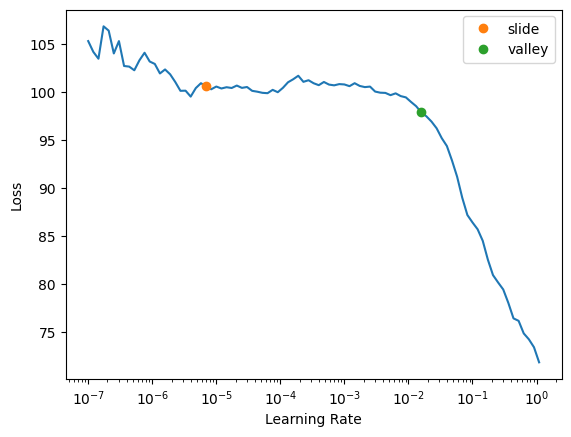

In [20]:
learn.lr_find(suggest_funcs=(slide,valley))

In [21]:
learn.fit_one_cycle(9,slice(6.309573450380412e-05, 0.013054606556892395))

epoch,train_loss,valid_loss,_rmse,time
0,4.120409,4.266267,2.065495,00:10
1,4.153863,4.586721,2.141663,00:10
2,4.121570,3.792982,1.947558,00:10
3,4.069562,3.802173,1.949916,00:10
4,4.031919,3.893600,1.973221,00:10
5,3.485606,3.729075,1.931081,00:10
6,3.602242,3.600235,1.897429,00:11
7,3.722648,3.592961,1.895511,00:10
8,3.632960,3.577912,1.891537,00:10


In [ ]:
#learn.fit_one_cycle(15,slice(6.309573450380412e-07, 0.019054606556892395))

epoch,train_loss,valid_loss,_rmse,time
0,3.926951,4.539420,2.130592,00:14
1,3.841202,3.569802,1.889392,00:17
2,3.627239,3.536179,1.880473,00:13


In [22]:
learn.show_results()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Rings_pred
0,2.0,-0.269037,-0.167711,-0.403633,-0.211118,0.039855,-0.378879,-0.311918,8.0,8.410287
1,2.0,-0.818528,-0.830658,-0.534702,-0.990936,-0.902869,-0.964274,-0.926740,9.0,7.684295
2,1.0,1.125824,1.056192,1.300263,1.533354,1.499241,1.134218,1.686253,9.0,12.944342
3,1.0,1.210361,1.260176,0.775987,1.586946,1.949790,2.314930,1.186710,10.0,10.672885
4,3.0,-0.226769,-0.167711,-0.534702,-0.024093,-0.606584,-0.344152,-0.427197,7.0,13.414396
5,1.0,0.872213,1.005196,0.775987,0.851971,0.759754,0.806794,0.948467,9.0,11.444970
6,3.0,-0.099963,-0.167711,-0.272564,-0.357676,-0.082576,-0.602123,-0.492522,9.0,8.219968
7,2.0,-0.015426,-0.014723,-0.272564,-0.360957,-0.268673,-0.403684,-0.388771,8.0,8.500035
8,1.0,0.745408,0.954200,0.644918,0.948217,0.938504,0.915936,0.725594,9.0,10.428607


In [ ]:
#row, clas, probs = learn.predict(df.iloc[0])
#row.show()

In [23]:
dl = learn.dls.test_dl(test_df)

In [24]:
nn_preds = learn.get_preds(dl=dl)
nn_preds

(tensor([[ 9.7576],
         [ 9.7149],
         [10.3073],
         ...,
         [12.8166],
         [12.9985],
         [ 8.7177]]),
 None)

In [61]:
a_preds, _ = learn.get_preds(dl=dl)

In [62]:
nn_preds_y = a_preds.squeeze(1)
nn_preds_y

tensor([ 9.7576,  9.7149, 10.3073,  ..., 12.8166, 12.9985,  8.7177])

In [63]:
nn_preds_y.shape

torch.Size([60411])

In [64]:
nn_preds_x = learn.get_preds()[0]
nn_preds_x

tensor([[14.9577],
        [11.4220],
        [11.2877],
        ...,
        [ 5.3558],
        [10.6479],
        [ 7.0545]])

In [65]:
nn_preds_x.shape

torch.Size([18123, 1])

In [ ]:
#nn_argmax = nn_preds_x.argmax(dim=1)
#nn_argmax

In [36]:
rmse(nn_preds_x, tensor(y_test))

TensorBase(6.4944)

In [ ]:
!ls

kaggle.json  models  sample_data  sub-tree.csv


In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.415621
1,90616,9.716002
2,90617,10.297346
3,90618,10.079777
4,90619,7.675570


In [ ]:
ls

kaggle.json  models/  sample_data/  submission.csv


In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

100% 964k/964k [00:00<00:00, 4.03MB/s]
Successfully submitted to Regression with an Abalone Dataset

Neural Network without id column

In [25]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.757600
1,90616,9.714918
2,90617,10.307315
3,90618,10.212436
4,90619,7.653612


In [26]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 4 with no id column + no random seed "

100% 964k/964k [00:00<00:00, 2.22MB/s]
Successfully submitted to Regression with an Abalone Dataset

Neural Network Ensemble

SuggestedLRs(slide=0.0063095735386013985, valley=0.005248074419796467)

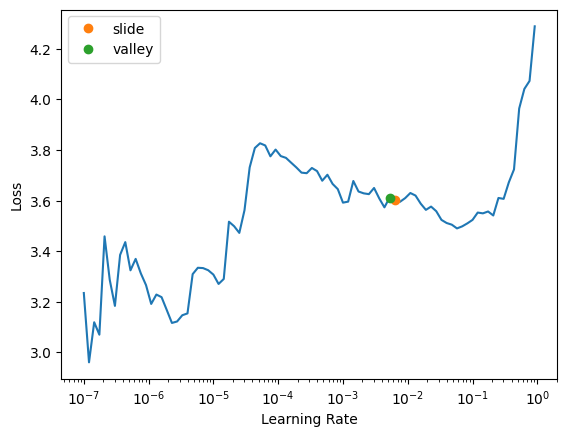

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(2, 0.14)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(3)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble Sub 3 with id column + no random seed "

100% 965k/965k [00:00<00:00, 2.29MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

Random Forest

In [27]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [28]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

#roc_auc_score(y_test, rf.predict(X_test))

In [29]:
#rf_preds = rf.predict(X_test)

In [42]:
#rmse(rf_preds, tensor(y_test))

In [35]:
dls = to.dataloaders(bs=64)

In [36]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data	 submission.csv


In [37]:
test_dl = dls.test_dl(test_df)

In [38]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [39]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [40]:
submit.to_csv('submission.csv', index=False)

In [41]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data	 submission.csv


In [42]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [45]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

100% 542k/542k [00:00<00:00, 796kB/s]
Successfully submitted to Regression with an Abalone Dataset

XGBoost

In [46]:
model = xgb.XGBRegressor(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [47]:
xgb_model = model.fit(X_train, y_train)

In [91]:
#xgb_preds = tensor(model.predict(X_test))

In [92]:
rmse(xgb_preds, tensor(y_test))

TensorBase(1.8413)

In [48]:
dls = to.dataloaders(bs=64)

In [49]:
test_dl = dls.test_dl(test_df)

In [50]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

XGBoost Submission code

In [51]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

,id,Rings
0,90615,9.739524
1,90616,9.736426
2,90617,10.058977
3,90618,10.181907
4,90619,7.623135


In [52]:
submit.to_csv('submission.csv', index=False)

In [53]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data	 submission.csv


In [54]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.739524
1,90616,9.736426
2,90617,10.058977
3,90618,10.181907
4,90619,7.623135


In [55]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 4 without id column"

100% 963k/963k [00:00<00:00, 1.85MB/s]
Successfully submitted to Regression with an Abalone Dataset

Model Ensemble

XGBoost + Random Forest

In [ ]:
avgs = (xgb_preds + rf_preds) / 2

In [58]:
nn_preds.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [66]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

(torch.Size([60411]), torch.Size([60411]), torch.Size([60411]))

In [67]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [70]:
avgs.shape

torch.Size([60411])

In [71]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data


In [72]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

,id,Rings
0,90615,9.832375
1,90616,9.483781
2,90617,9.788764
3,90618,9.798114
4,90619,7.758915


In [73]:
submit.to_csv('submission.csv', index=False)

In [74]:
!ls

'kaggle (1).json'   kaggle.json   models   sample_data	 submission.csv


In [75]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.832375
1,90616,9.483781
2,90617,9.788764
3,90618,9.798114
4,90619,7.758915


In [76]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"

100% 961k/961k [00:00<00:00, 2.28MB/s]
Successfully submitted to Regression with an Abalone Dataset